In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from seaborn import set_style
set_style("whitegrid")
import csv
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings("ignore")

In [70]:
#Import the data
rec = pd.read_csv('NFLRecords.csv')
picks = pd.read_csv('draftpicks.csv')
combine_data = pd.read_csv('Data_Bowl_Combine.csv')
#Truncate data to the appropriate years
#combine_data=combine_data.loc[combine_data['Year']>2002]
#picks=picks.truncate(after=4079)

In [71]:
#Input 0 for anamolous DrAV values
picks['DrAV'].fillna(0)
for pick in picks.index:
    if picks.loc[pick,'DrAV']<0:
        picks.loc[pick,'DrAV']=0 

In [72]:
#Combine positions usually considered roughly equivalent
new = 'C', 'G', 'OG', 'OL', 'OT'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'OL')
combine_data['Pos'].nunique()


new = 'FS', 'SS', 'S', 'DB', 'CB'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'DB')
combine_data['Pos'].nunique()


new = 'TE', 'FB'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'TE')
combine_data['Pos'].nunique()

new = 'NT', 'DL', 'DT'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'DT')
combine_data['Pos'].nunique()


new = 'LB', 'OLB', 'ILB'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'LB')
combine_data['Pos'].nunique()


new = 'EDGE'
combine_data['Pos'] = combine_data['Pos'].replace(new, 'DE')
combine_data['Pos'].nunique()


#Remove K, P, LS
new = 'K' , 'P' , 'LS'
combine_data = combine_data[~combine_data['Pos'].isin(new)]
combine_data['Pos'].nunique()


9

In [73]:
#Remove UDFAs and check how much data is missing.
no_UDFAs = combine_data[~combine_data['Round'].isna()]
missing_no_UDFAs = no_UDFAs.isna().sum()
missing_no_UDFAs = missing_no_UDFAs/len(no_UDFAs) * 100
print(missing_no_UDFAs)

Player        0.000000
Pos           0.000000
Ht            0.000000
Wt            0.000000
Forty         2.058672
Vertical     20.458055
BenchReps    29.516212
BroadJump    21.204323
Cone         33.530623
Shuttle      32.527020
Year          0.000000
Pfr_ID        2.161606
AV            5.352548
Team          0.000000
Round         0.000000
Pick          0.000000
dtype: float64


In [74]:
#Add statistics to the data set.
no_UDFAs['DrAV']=[picks.loc[(picks['Tm']==no_UDFAs.loc[pick,'Team'])& (picks['Pick']==no_UDFAs.loc[pick,'Pick']), 'DrAV'].mean() for pick in no_UDFAs.index]
#These statistics ended up not being predictable based on combine data.
#no_UDFAs['SRS0']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']==no_UDFAs.loc[pick,'Year']-1), 'SRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['SRSAv']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']>=no_UDFAs.loc[pick,'Year']) & (rec['Year']<=no_UDFAs.loc[pick,'Year']+3), 'SRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['OSRS0']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']==no_UDFAs.loc[pick,'Year']-1), 'OSRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['OSRSAv']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']>=no_UDFAs.loc[pick,'Year']) & (rec['Year']<=no_UDFAs.loc[pick,'Year']+3), 'OSRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['DSRS0']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']==no_UDFAs.loc[pick,'Year']-1), 'DSRS'].mean() for pick in no_UDFAs.index]
#no_UDFAs['DSRSAv']=[rec.loc[(rec['Tm']==no_UDFAs.loc[pick,'Team'])& (rec['Year']>=no_UDFAs.loc[pick,'Year']) & (rec['Year']<=no_UDFAs.loc[pick,'Year']+3), 'DSRS'].mean() for pick in no_UDFAs.index]

In [75]:
#We will estimate how much an individual draft pick is worth.
#I use a PoissonRegressor due to the right skew of the distribution.
dravreg=PoissonRegressor(alpha=0)
#The value of k and the exponent 0.5 were chosen via hyperparameter tuning 
k=180.01
draftpick=np.array([[(i+k)**(-0.5)] for i in range(1,257)])
picks['inv']=(picks['Pick']+k)**(-0.5)
dravreg.fit( picks[['inv']],picks['DrAV'])

PoissonRegressor(alpha=0)

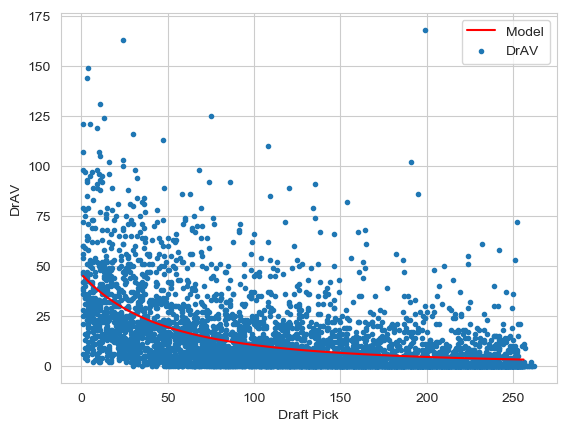

In [76]:
plt.scatter(picks['Pick'],picks['DrAV'],marker='.')
plt.plot(range(1,257),dravreg.predict(draftpick),color='red', label='Model')
plt.xlabel('Draft Pick')
plt.ylabel('DrAV')
plt.legend();

In [77]:
# It was used to determine that combine data provided no further information than the draft slot about the teams future performance.

no_UDFAs['inv']=(no_UDFAs['Pick']+k)**(-0.5)

In [78]:
#A sanity check statistic; the average value of each position.
for Pos in ["QB", "RB", "WR","TE","OL","DE","DT","LB","DB"]:
    print("The average DrAV of a "+Pos+" is " + str(no_UDFAs.loc[no_UDFAs['Pos']==Pos, 'DrAV'].mean()))

The average DrAV of a QB is 17.46723300970874
The average DrAV of a RB is 14.450471698113208
The average DrAV of a WR is 12.402192134107025
The average DrAV of a TE is 7.78164924506388
The average DrAV of a OL is 16.342450824029772
The average DrAV of a DE is 15.41690408357075
The average DrAV of a DT is 14.232382382382381
The average DrAV of a LB is 14.207176391683435
The average DrAV of a DB is 11.84911111111111


We note that based on current NFL salaries this does not match teams valuation of the positions. This may cause error when comparing players from different positions using this metric.

In [166]:
#Filter the desired position
QB=no_UDFAs[no_UDFAs['Pos']=='QB']
#Interpolate blank values
QB=QB.fillna(value=QB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
#Model for the DrAV of a QB as a function of draft pick.
QBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
QBmodelAv.fit(QB[['inv']],QB['DrAV'])
#The main model predicting player performance based on combine data, the features were chosen by hyperparameter tuning.
#I used the full training set for the optimal model.
QBmodel=LinearRegression()
QBmodel.fit(QB[['Wt','Forty','BroadJump']],QB['DrAV'])
print(QBmodel.coef_)
for fea in ['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']:
    QBmodel=LinearRegression()
    QBmodel.fit(QB[[fea]],QB['DrAV'])
    print(QBmodel.score(QB[[fea]],QB['DrAV']))

[ 0.20071638 -3.85339112  0.53588997]
0.009641881806362496
0.004665056146655688
0.004830685268894408
0.002196773557051057
6.124319037581483e-05
0.01360220725868988
0.010695357335420819
0.0010068144895274411


In [139]:
RB=no_UDFAs[no_UDFAs['Pos']=='RB']
RB=RB.fillna(value=RB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
RBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
RBmodelAv.fit(RB[['inv']],RB['DrAV'])
RBmodel=LinearRegression()
RBmodel.fit(RB[['Wt','Forty','Vertical','BroadJump','Cone','Shuttle']],RB['DrAV'])
print(RBmodel.coef_)

[  0.15135947 -35.33144571  -0.0609151    0.41195371 -14.85939837
  21.86358627]


In [140]:
TE=no_UDFAs[no_UDFAs['Pos']=='TE']
TE=TE.fillna(value=TE.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
TEmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
TEmodelAv.fit(TE[['inv']],TE['DrAV'])
TEmodel=LinearRegression()
TEmodel.fit(TE[['Ht','Forty','BenchReps','BroadJump','Shuttle']],TE['DrAV'])
TEmodel.coef_

array([  1.09868894, -17.89166464,   0.12615689,   0.11507037,
         0.70443898])

In [170]:
OL=no_UDFAs[no_UDFAs['Pos']=='OL']
OL=OL.fillna(value=OL.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
OLmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
OLmodelAv.fit(OL[['inv']],OL['DrAV'])
OLmodel=LinearRegression()
OLmodel.fit(OL[['Vertical','BenchReps','Shuttle']],OL['DrAV'])
print(OLmodel.score(OL[['Vertical','BenchReps','Shuttle']],OL['DrAV']))
print(OLmodel.coef_)

0.03341081018739733
[  0.61636607   0.11382624 -12.80353421]


In [179]:
WR=no_UDFAs[no_UDFAs['Pos']=='WR']
WR=WR.fillna(value=WR.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
WRmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
WRmodelAv.fit(WR[['inv']],WR['DrAV'])
#WRmodel=LinearRegression()
#WRmodel.fit(WR[['Wt','Forty','Vertical']],WR['DrAV'])
#print(WRmodel.score(WR[['Wt','Forty','Vertical']],WR['DrAV']))

for fea in ['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']:
    WRmodel=LinearRegression()
    WRmodel.fit(WR[[fea]],WR['DrAV'])
    print(WRmodel.score(WR[[fea]],WR['DrAV']))
WRmodel=LinearRegression()
WRmodel.fit(WR[['Wt']],WR['DrAV'])
print(WRmodel.coef_)
print(WRmodel.score(WR[['Wt']],WR['DrAV']))

0.005338638336469526
0.010395935600429507
0.004744338784189561
0.003092863834146753
0.003950546432670454
0.0005848036582932759
0.0003122374750444967
0.0001256202451944688
[0.11096945]
0.010395935600429507


In [198]:
DB=no_UDFAs[no_UDFAs['Pos']=='DB']
DB=DB.fillna(value=DB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
DBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
DBmodelAv.fit(DB[['inv']],DB['DrAV'])
for fea in ['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']:
    DBmodel=LinearRegression()
    DBmodel.fit(DB[[fea]],DB['inv'])
    print(DBmodel.score(DB[[fea]],DB['inv']))
DBmodel=LinearRegression()
#DBmodel.fit(DB[['Ht','Wt','Forty','Cone','Shuttle']],DB['DrAV'])
DBmodel.fit(DB[['Forty','BroadJump']],DB['inv'])
print(DBmodel.coef_)

0.0005414887136415691
0.00039876616907774665
0.11550626332404179
0.034887034640695536
0.0003591264403105532
0.06211532888167648
0.027362288906028542
0.027212768859583347
[-0.02300477  0.00021773]


In [144]:
LB=no_UDFAs[no_UDFAs['Pos']=='LB']
LB=LB.fillna(value=LB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
LBmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
LBmodelAv.fit(LB[['inv']],LB['DrAV'])
LBmodel=LinearRegression()
LBmodel.fit(LB[['Wt','Forty','Vertical','BenchReps','Cone','Shuttle']],LB['DrAV'])
print(LBmodel.coef_)

[  0.22913643 -25.61758031   0.40379287  -0.1775404  -11.21633788
  -5.21211304]


In [145]:
DT=no_UDFAs[no_UDFAs['Pos']=='DT']
DT=DT.fillna(value=DT.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
DTmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
DTmodelAv.fit(DT[['inv']],DT['DrAV'])
DTmodel=LinearRegression()
DTmodel.fit(DT[['Wt','Forty','BenchReps','Cone','Shuttle']],DT['DrAV'])
print(DTmodel.coef_)

[  0.23984504 -19.04126132   0.24567439 -14.83357181   7.05840612]


In [146]:
DE=no_UDFAs[no_UDFAs['Pos']=='DE']
DE=DE.fillna(value=DE.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
DEmodelAv=PoissonRegressor(alpha=0,max_iter=10000)
DEmodelAv.fit(DE[['inv']],DE['DrAV'])
DEmodel=LinearRegression()
DEmodel.fit(DE[['Wt','Forty','BenchReps','BroadJump','Cone','Shuttle']],DE['DrAV'])
print(DEmodel.coef_)

[  0.48167469 -36.31444487   0.22826092   0.38332667 -11.43488555
  12.10680788]


In [88]:
Models=[QBmodel,RBmodel,WRmodel,TEmodel,OLmodel,DEmodel,DTmodel,LBmodel,DBmodel]
ModelAv=[dravreg,QBmodelAv,RBmodelAv,WRmodelAv,TEmodelAv,OLmodelAv,DEmodelAv,DTmodelAv,LBmodelAv,DBmodelAv]

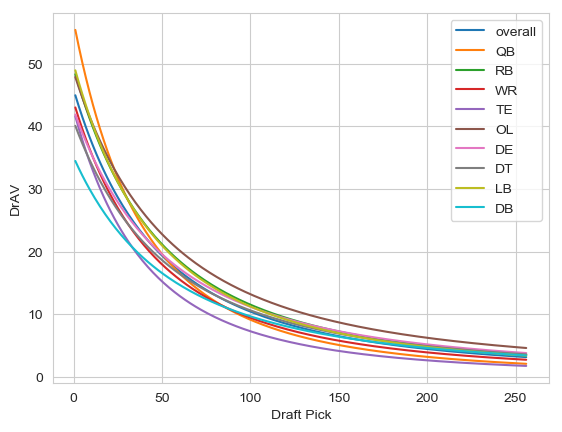

In [200]:
#plt.scatter(picks['Pick'],picks['DrAV'],marker='.')
plt.plot(range(1,257),dravreg.predict(draftpick), label='overall')
plt.plot(range(1,257),QBmodelAv.predict(draftpick), label='QB')
plt.plot(range(1,257),RBmodelAv.predict(draftpick), label='RB')
plt.plot(range(1,257),WRmodelAv.predict(draftpick), label='WR')
plt.plot(range(1,257),TEmodelAv.predict(draftpick), label='TE')
plt.plot(range(1,257),OLmodelAv.predict(draftpick), label='OL')
plt.plot(range(1,257),DEmodelAv.predict(draftpick), label='DE')
plt.plot(range(1,257),DTmodelAv.predict(draftpick), label='DT')
plt.plot(range(1,257),LBmodelAv.predict(draftpick), label='LB')
plt.plot(range(1,257),DBmodelAv.predict(draftpick), label='DB')
plt.xlabel('Draft Pick')
plt.ylabel('DrAV')
plt.legend()

As a bonus result, we can give a table showing the value of a pick in the various rounds for each position. As expected first round quarterbacks are the most valuable.

In [201]:
table=np.array([model.predict([[(i+k)**-0.5 ] for i in [0,16,32,64,96,128,160,250]]) for model in ModelAv])

In [202]:
pd.DataFrame(table, index=["All","QB", "RB", "WR","TE","OL","DE","DT","LB","DB"], columns=[0,16,32,64,96,128,160,250])

,0,16,32,64,96,128,160,250
All,45.910062,33.623381,25.526545,15.996791,10.901417,7.899774,5.997757,3.283988
QB,56.834050,38.702013,27.550216,15.478865,9.644294,6.482138,4.614650,2.194951
RB,49.319057,36.339579,27.736927,17.540734,12.043095,8.781950,6.703359,3.713594
WR,43.959911,31.823761,23.913608,14.727380,9.893990,7.084234,5.323668,2.850226
TE,42.657805,29.427736,21.190018,12.139423,7.685385,5.235263,3.769997,1.838744
OL,48.760976,37.053709,29.064168,19.250609,13.728614,10.335450,8.107302,4.767392
DE,42.691442,32.220609,25.120950,16.469171,11.646664,8.706367,6.788292,3.939385
DT,40.853492,30.783789,23.966531,15.674385,11.062630,8.256005,6.427979,3.718678
LB,49.982509,36.534110,27.688196,17.300378,11.761302,8.505602,6.446513,3.516317
DB,35.109119,26.778867,21.073911,14.036275,10.055880,7.599598,5.980866,3.542320


In [126]:
#Import the testing data
testpicks = pd.read_csv('PicksTest.csv')
testcombine = pd.read_csv('TestCombineData.csv')


In [127]:
#Combine positions usually considered roughly equivalent
new = 'C', 'G', 'OG', 'OL', 'OT'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'OL')
testcombine['Pos'].nunique()


new = 'FS', 'SS', 'S', 'DB', 'CB'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'DB')
testcombine['Pos'].nunique()


new = 'TE', 'FB'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'TE')
testcombine['Pos'].nunique()

new = 'NT', 'DL', 'DT'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'DT')
testcombine['Pos'].nunique()


new = 'LB', 'OLB', 'ILB'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'LB')
testcombine['Pos'].nunique()


new = 'EDGE'
testcombine['Pos'] = testcombine['Pos'].replace(new, 'DE')
testcombine['Pos'].nunique()


#Remove K, P, LS
new = 'K' , 'P' , 'LS'
testcombine = testcombine[~testcombine['Pos'].isin(new)]
testcombine['Pos'].nunique()

9

In [128]:
#Remove UDFAs
testno_UDFAs = testcombine[~testcombine['Pick'].isna()]
testno_UDFAs['DrAV']=[testpicks.loc[(testpicks['Tm']==testno_UDFAs.loc[pick,'Team'])& (testpicks['Pick']==testno_UDFAs.loc[pick,'Pick']), 'DrAV'].mean() for pick in testno_UDFAs.index]

In [129]:
#A scaling statistic to account for the longer time older picks had to build up DrAV.
scale=no_UDFAs['DrAV'].mean()/testno_UDFAs['DrAV'].mean()
testno_UDFAs['adDrAV']=testno_UDFAs['DrAV']*scale

In [130]:
testno_UDFAs['adDrAV'].mean()

13.686052496139991

In [196]:
testno_UDFAs['inv']=(testno_UDFAs['Pick']+k)**(-0.5)

In [147]:
poslist=['QB', 'RB', 'WR','TE','OL','DE','DT','LB','DB']
TestQB=testno_UDFAs[testno_UDFAs['Pos']=='QB']
TestQB=TestQB.fillna(value=QB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
QBmodel.score(TestQB[['Wt','Forty','BroadJump']],TestQB['DrAV'])

0.02673058345844348

In [148]:
TestRB=testno_UDFAs[testno_UDFAs['Pos']=='RB']
TestRB=TestRB.fillna(value=RB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
RBmodel.score(TestRB[['Wt','Forty','Vertical','BroadJump','Cone','Shuttle']],TestRB['DrAV'])

-0.0563166216746962

In [181]:
TestWR=testno_UDFAs[testno_UDFAs['Pos']=='WR']
TestWR=TestWR.fillna(value=WR.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
WRmodel.score(TestWR[['Wt']],TestWR['DrAV'])


-0.03389937046548952

In [199]:
TestDB=testno_UDFAs[testno_UDFAs['Pos']=='DB']
TestDB=TestDB.fillna(value=DB.loc[:,['Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']].mean())
DBmodel.score(TestDB[['Forty','BroadJump']],TestDB['inv'])

-0.02553786639864364